# 프로젝트 : 커스텀 프로젝트 직접 만들기
- 한국어 데이터셋에 도전해보겠습니다.
- 앞서 본 GLUE benchmark의 한국어 버전 KLUE benchmark를 들어보신 적 있나요?

- GLUE와 마찬가지로 한국어 자연어처리에 대한 이해도를 높이기 위해 만들어진 데이터셋 benchmark입니다. 총 8가지의 데이터셋이 있습니다. 다만 이번 시간에 진행할 프로젝트는 KLUE의 dataset을 활용하는 것이 아닌, model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task를 도전해보겠습니다.
  
  
    
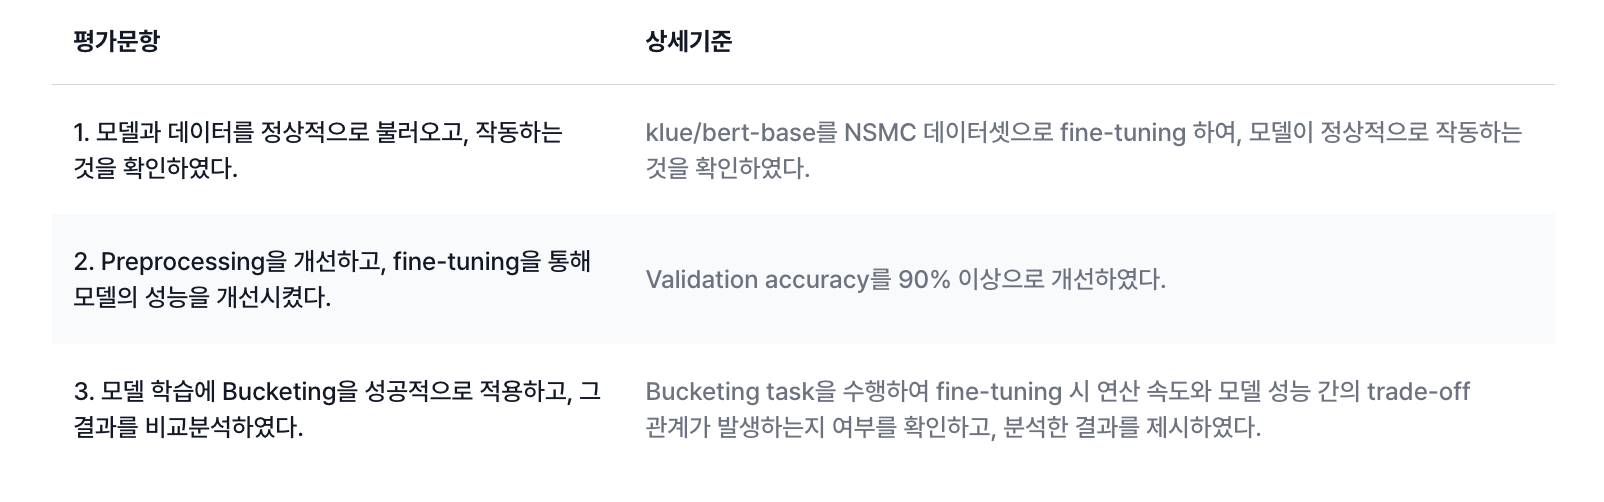
   

In [19]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


# STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성
데이터셋은 깃허브에서 다운받거나, Huggingface datasets에서 가져올 수 있습니다. 앞에서 배운 방법들을 활용해봅시다!


In [1]:
import datasets
from datasets import load_dataset

train_data = load_dataset('nsmc', split='train[:1%]')
val_data = load_dataset('nsmc', split='train[-1%:]')
test_data = load_dataset('nsmc', split='test[:1%]')

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)
Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


In [2]:
train_data

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 1500
})

In [3]:
val_data

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 1500
})

In [5]:
test_data

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 500
})

# STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [6]:
from transformers import BertForSequenceClassification, BertTokenizer

Huggingface_model_path = 'klue/bert-base'

model = BertForSequenceClassification.from_pretrained(Huggingface_model_path)
tokenizer = BertTokenizer.from_pretrained(Huggingface_model_path)
config = model.config

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

In [7]:
cols = train_data.column_names
cols

['id', 'document', 'label']

In [8]:
for i in range(5):
    for col in cols:
        print(col, ":", train_data[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




# STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기


In [9]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [10]:
train = train_data.map(transform, batched=True)
val = val_data.map(transform, batched=True)
test = test_data.map(transform, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.


In [11]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [12]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [13]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train,    # training dataset
    eval_dataset=val,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 1500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 564


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.384206,0.836000
2,No log,0.550185,0.843333
3,0.309800,0.612150,0.855333


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/m

TrainOutput(global_step=564, training_loss=0.2989575085065044, metrics={'train_runtime': 611.3953, 'train_samples_per_second': 7.36, 'train_steps_per_second': 0.922, 'total_flos': 1183999749120000.0, 'train_loss': 0.2989575085065044, 'epoch': 3.0})

In [14]:
trainer.evaluate(test)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8


{'eval_loss': 0.5715899467468262,
 'eval_accuracy': 0.866,
 'eval_runtime': 18.1594,
 'eval_samples_per_second': 27.534,
 'eval_steps_per_second': 3.469,
 'epoch': 3.0}

# STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교 

In [15]:
from transformers import BertForSequenceClassification, BertTokenizer

Huggingface_model_path = 'klue/bert-base'

model = BertForSequenceClassification.from_pretrained(Huggingface_model_path)
tokenizer = BertTokenizer.from_pretrained(Huggingface_model_path)
config = model.config

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_arguments = TrainingArguments(
    output_dir,                                 # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    group_by_length = True,              #요거 추가 !!! 
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    data_collator = data_collator,    #요거 추가 !!
    train_dataset=train,    # training dataset
    eval_dataset=val,       # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 1500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 564


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.364608,0.836000
2,No log,0.601462,0.838667
3,0.302600,0.690262,0.841333


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/m

TrainOutput(global_step=564, training_loss=0.29039256792541934, metrics={'train_runtime': 613.8897, 'train_samples_per_second': 7.33, 'train_steps_per_second': 0.919, 'total_flos': 1183999749120000.0, 'train_loss': 0.29039256792541934, 'epoch': 3.0})

In [18]:
trainer.evaluate(test)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8


{'eval_loss': 0.6291016936302185,
 'eval_accuracy': 0.854,
 'eval_runtime': 18.1826,
 'eval_samples_per_second': 27.499,
 'eval_steps_per_second': 3.465,
 'epoch': 3.0}

# 회고
- 텍스트 데이터를 이리저리 만져보는 방법을 배웠는데, 좀 더 공부가 필요하겠다